<a href="https://colab.research.google.com/github/juwayriyarizwan/juwayriyarizwan/blob/main/LLM_Fact_Maker_Zero_Shot_Prompts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# M4 - LLM Fact Maker - Zero Shot Prompts
# COSC 523: Aritificial Intelligence
# Student Name: Juwayriya Rizwan

# %%capture
!pip3 install --upgrade pip setuptools wheel scikit-build-core
!pip3 install "langchain>=0.1.17" "openai>=1.13.3" "langchain_openai>=0.1.6" "transformers>=4.40.1" "datasets>=2.18.0" "accelerate>=0.27.2" "sentence-transformers>=2.5.1" "duckduckgo-search>=5.2.2"
!pip3 install "llama-cpp-python"
!CMAKE_ARGS="-DGGML_CUDA=ON"
!pip3 install torch --index-url https://download.pytorch.org/whl/cu121
!pip3 install transformers
!pip3 uninstall numpy -y
!pip3 install numpy==1.26.4

Looking in indexes: https://download.pytorch.org/whl/cu121
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 w

In [4]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import time
import os
import numpy

# Load model and tokenizer
model = AutoModelForCausalLM.from_pretrained(
    "microsoft/Phi-3-mini-4k-instruct",
    device_map="auto",
    dtype=torch.bfloat16,
    trust_remote_code=False,
)
tokenizer = AutoTokenizer.from_pretrained("microsoft/Phi-3-mini-4k-instruct")

# Create a pipeline
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    return_full_text=False,
    max_new_tokens=3,
    do_sample=False,
)
print("model loaded successfully")


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


model loaded successfully


In [5]:
import numpy as np
print(np.__version__)

1.26.4


In [6]:
import json

# Baseline Prompts and Property Assessment
def rating(noun, pre_prompt, pipe, tokenizer):
    prompt = pre_prompt + noun

    # Prompt
    messages = [
        {"role": "user", "content": prompt}
    ]

    prompt_template = tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
    print(f"DEBUG: Prompt sent to model: \n{prompt_template}")
    # Generate the output
    output = pipe(prompt_template, num_return_sequences=1)[0]
    response = output["generated_text"].strip()

    # Get integers
    rating = ''.join(filter(str.isdigit, response))

    if rating and 1 <= int(rating) <= 10:
        return int(rating)
    else:
        print("fail")
        return None

# Testing all properties
def load_data(nouns_text='nouns.txt', prompts_text='baseline-prompts.jsonl'):
    # read nouns and prompts from the file
    # nouns
    with open(nouns_text, 'r') as f:
        nouns = [line.strip() for line in f if line.strip()]

    # prompts
    properties = []
    with open(prompts_text, 'r') as f:
        for line in f:
            properties.append(json.loads(line))

    return nouns, properties

In [7]:
#Baseline prompts and property assessment
def property_assessment(nouns_text, properties_text, pipe, tokenizer):
    ratings = []
    count = 0

    # iterate through prompts
    for properties in properties_text:
        property_name = properties['property']
        pre_prompt = properties['pre-prompt']

        # iterate through nouns
        for nouns in nouns_text:
            count += 1

            # get ratings
            index = count
            print(f"Running: {property_name} for {nouns}...")
            get_ratings = rating(nouns, pre_prompt, pipe, tokenizer)

            result = {
                "noun": nouns,
                "property": property_name,
                "rating": get_ratings
            }

            ratings.append(result)

            if get_ratings is None:
                print(f"Failed for {nouns}.")
            else:
                print(f"Rating: {get_ratings}")
    # summary
    successful_ratings = sum(1 for item in ratings if item['rating'] is not None)

    print(f"\n\n--- Assessment Session Ended ---")
    print(f"Total ratings collected: {len(ratings)}")
    print(f"Successful numerical ratings: {successful_ratings}")

    # Print the full list of collected ratings
    print("\n--- Full Collected Data (List of Dictionaries) ---")
    return ratings

In [8]:
# Get results
nouns_text, property_text = load_data(prompts_text='baseline-prompts.jsonl')
final_results = property_assessment(nouns_text, property_text, pipe, tokenizer)
print(final_results)

Running: energy_level for Pasta...
DEBUG: Prompt sent to model: 
<|user|>
Output ONLY a number 1-10. How much energy level would you rate this noun: Pasta<|end|>
<|assistant|>

Rating: 3
Running: energy_level for Sushi...
DEBUG: Prompt sent to model: 
<|user|>
Output ONLY a number 1-10. How much energy level would you rate this noun: Sushi<|end|>
<|assistant|>

Rating: 3
Running: energy_level for Taco...
DEBUG: Prompt sent to model: 
<|user|>
Output ONLY a number 1-10. How much energy level would you rate this noun: Taco<|end|>
<|assistant|>

Rating: 3
Running: energy_level for Curry...
DEBUG: Prompt sent to model: 
<|user|>
Output ONLY a number 1-10. How much energy level would you rate this noun: Curry<|end|>
<|assistant|>

Rating: 3
Running: energy_level for Paella...
DEBUG: Prompt sent to model: 
<|user|>
Output ONLY a number 1-10. How much energy level would you rate this noun: Paella<|end|>
<|assistant|>

Rating: 3
Running: energy_level for Hummus...
DEBUG: Prompt sent to model: 

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Rating: 3
Running: energy_level for Samosa...
DEBUG: Prompt sent to model: 
<|user|>
Output ONLY a number 1-10. How much energy level would you rate this noun: Samosa<|end|>
<|assistant|>

Rating: 3
Running: energy_level for Dumpling...
DEBUG: Prompt sent to model: 
<|user|>
Output ONLY a number 1-10. How much energy level would you rate this noun: Dumpling<|end|>
<|assistant|>

Rating: 3
Running: energy_level for Pizza...
DEBUG: Prompt sent to model: 
<|user|>
Output ONLY a number 1-10. How much energy level would you rate this noun: Pizza<|end|>
<|assistant|>

Rating: 3
Running: energy_level for Statue of Liberty...
DEBUG: Prompt sent to model: 
<|user|>
Output ONLY a number 1-10. How much energy level would you rate this noun: Statue of Liberty<|end|>
<|assistant|>

Rating: 3
Running: energy_level for Eiffel Tower...
DEBUG: Prompt sent to model: 
<|user|>
Output ONLY a number 1-10. How much energy level would you rate this noun: Eiffel Tower<|end|>
<|assistant|>

Rating: 7
Running: 

In [9]:
# Upload ratings to file
import pandas as pd
import json

with open("ratings.jsonl", "w") as f:
  json.dump(final_results, f)

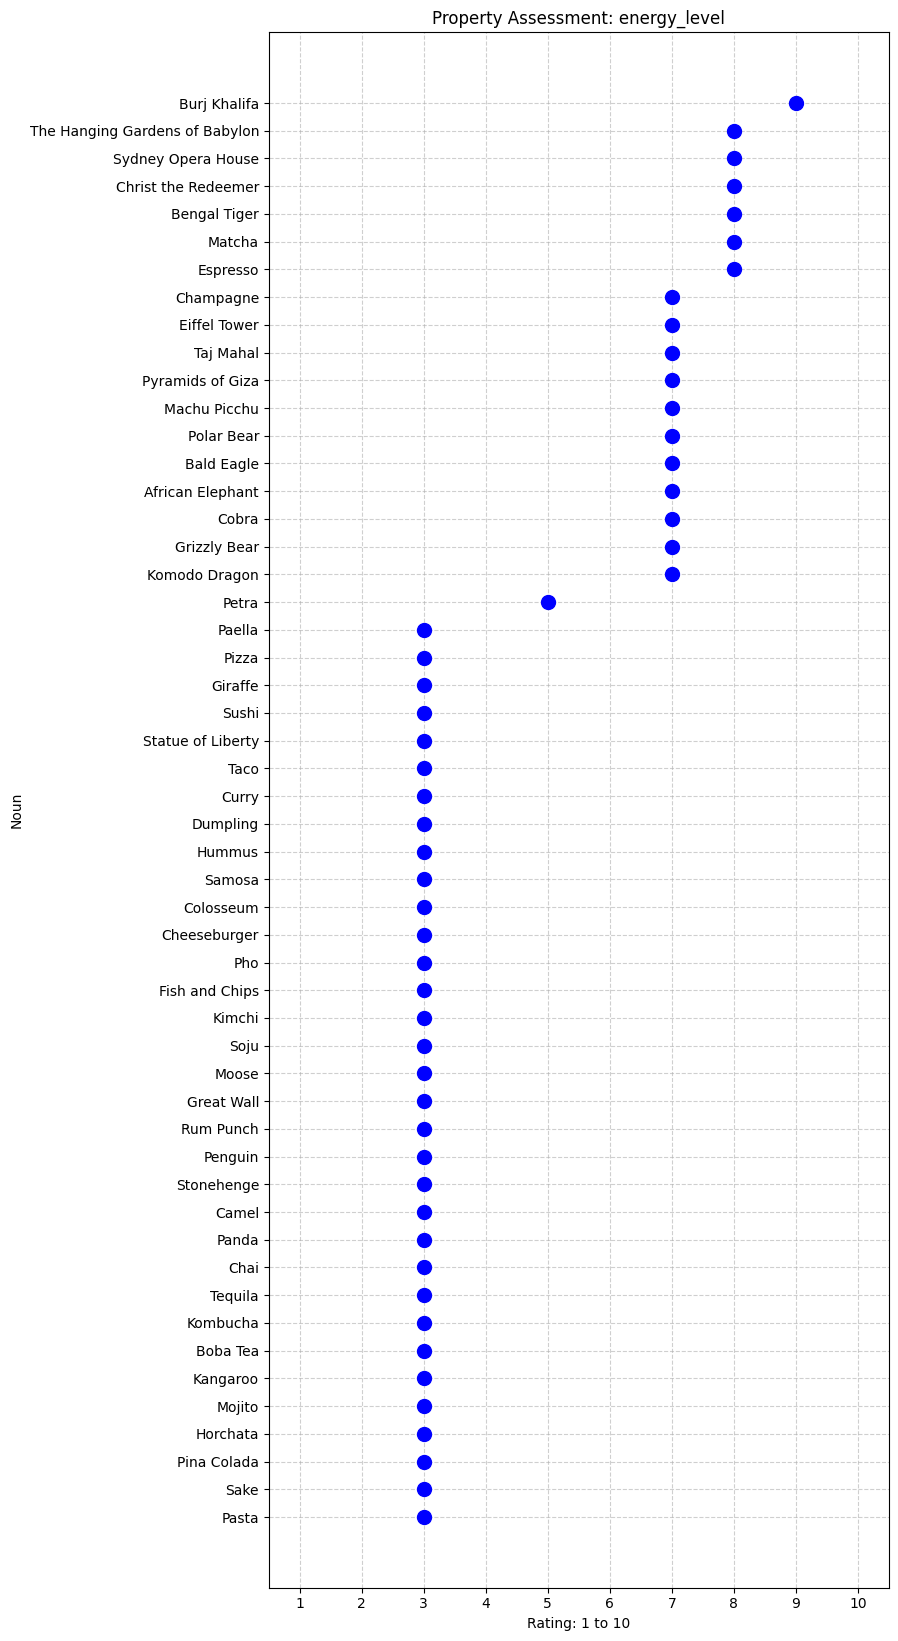

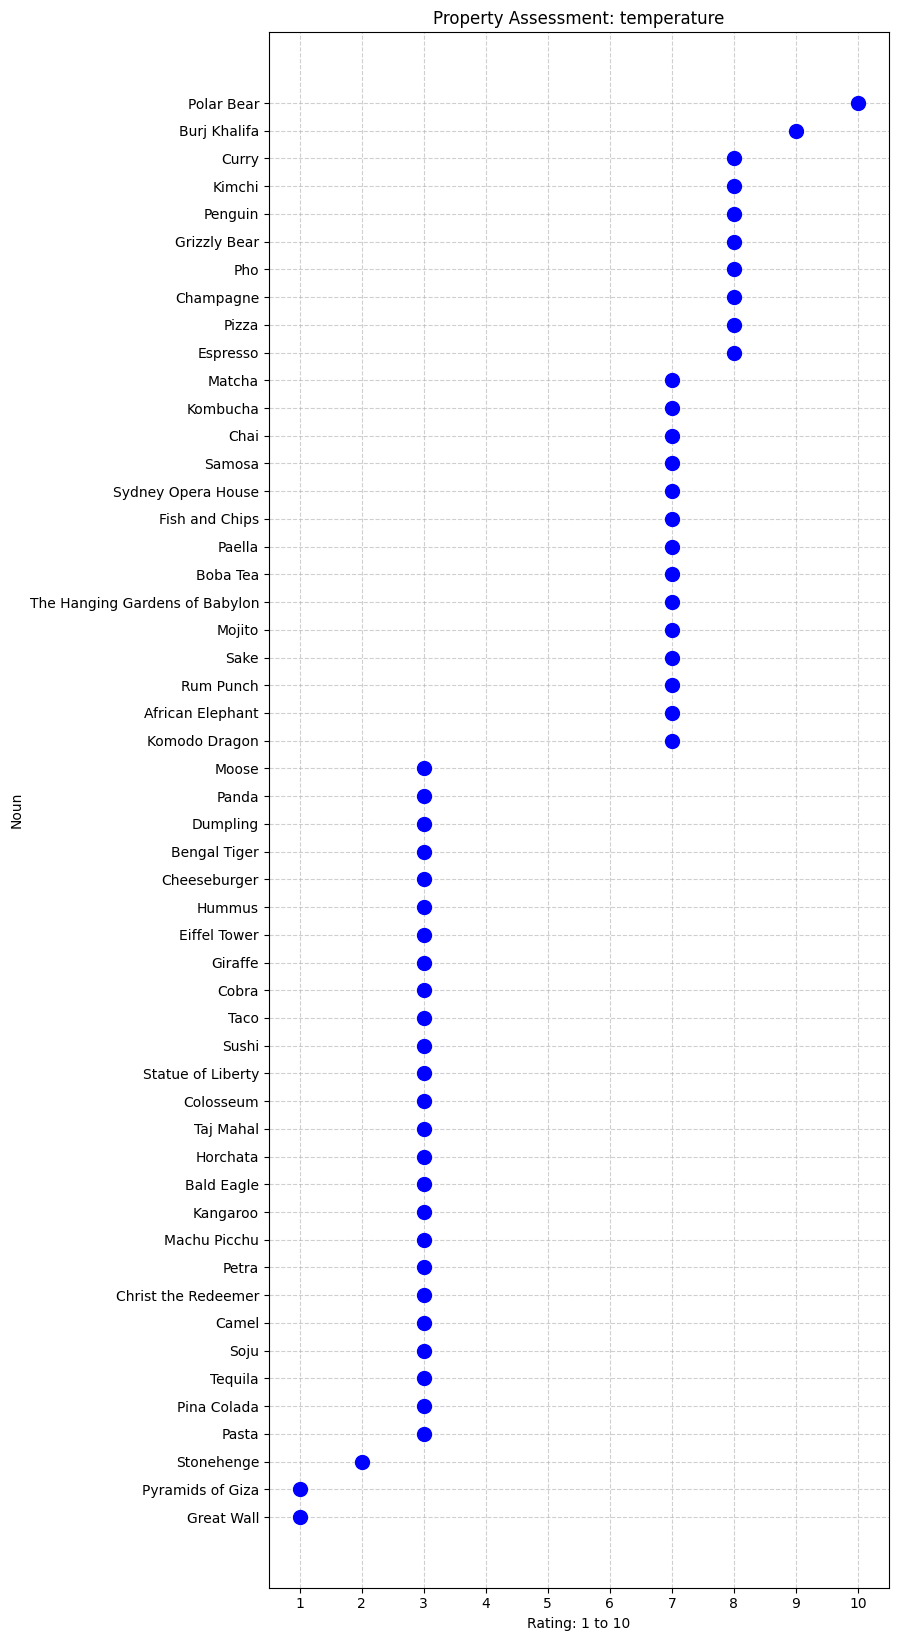

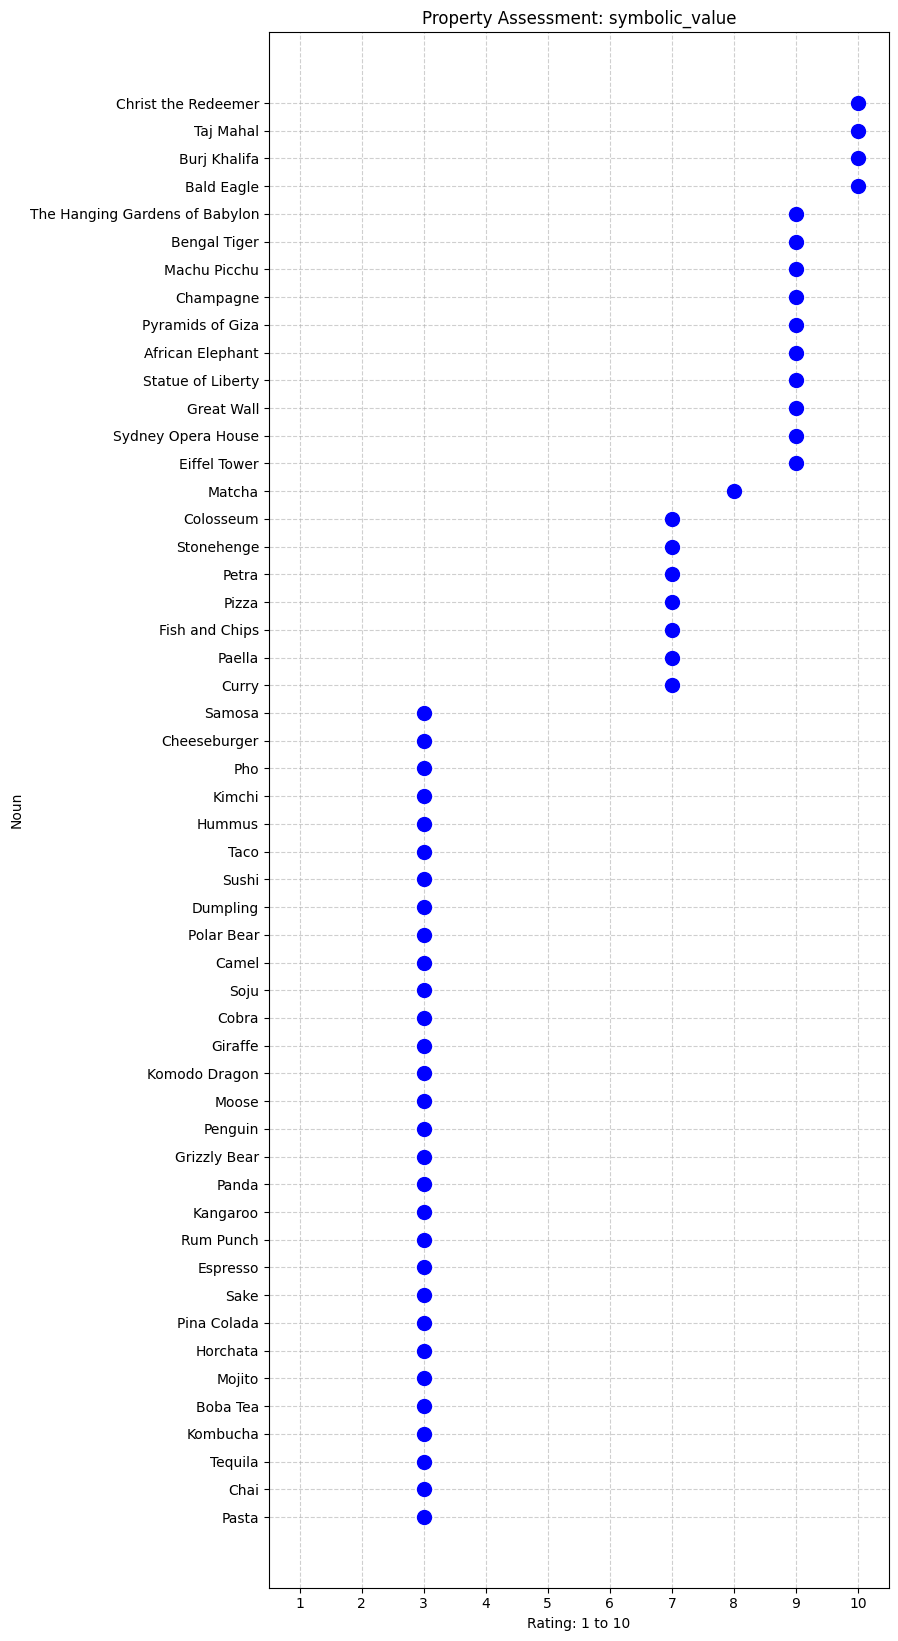

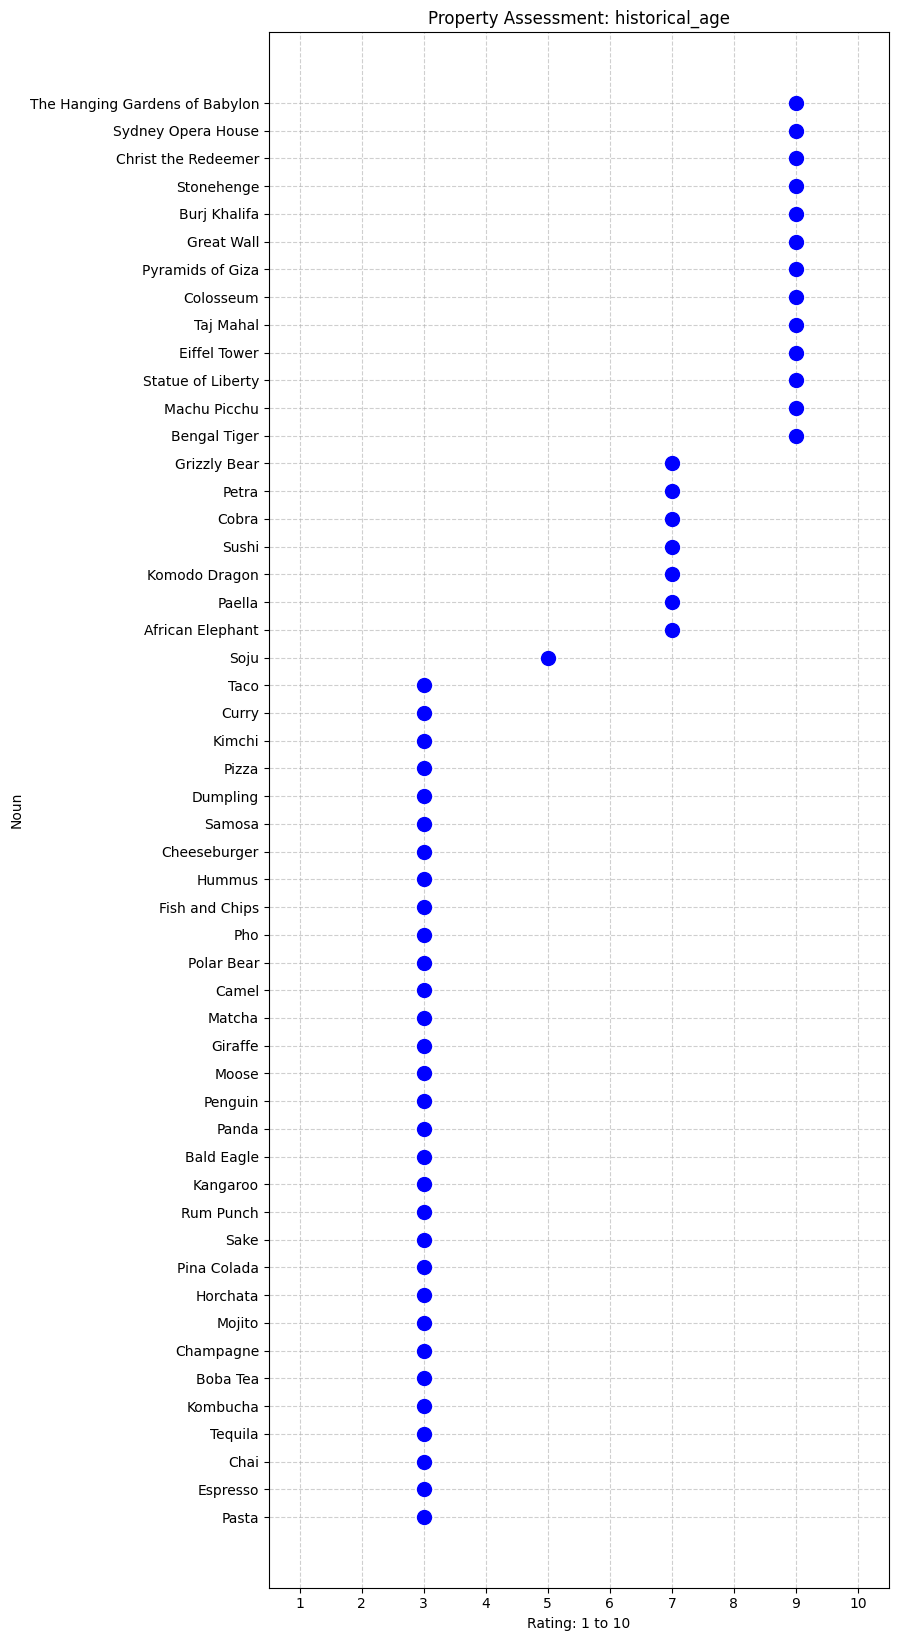

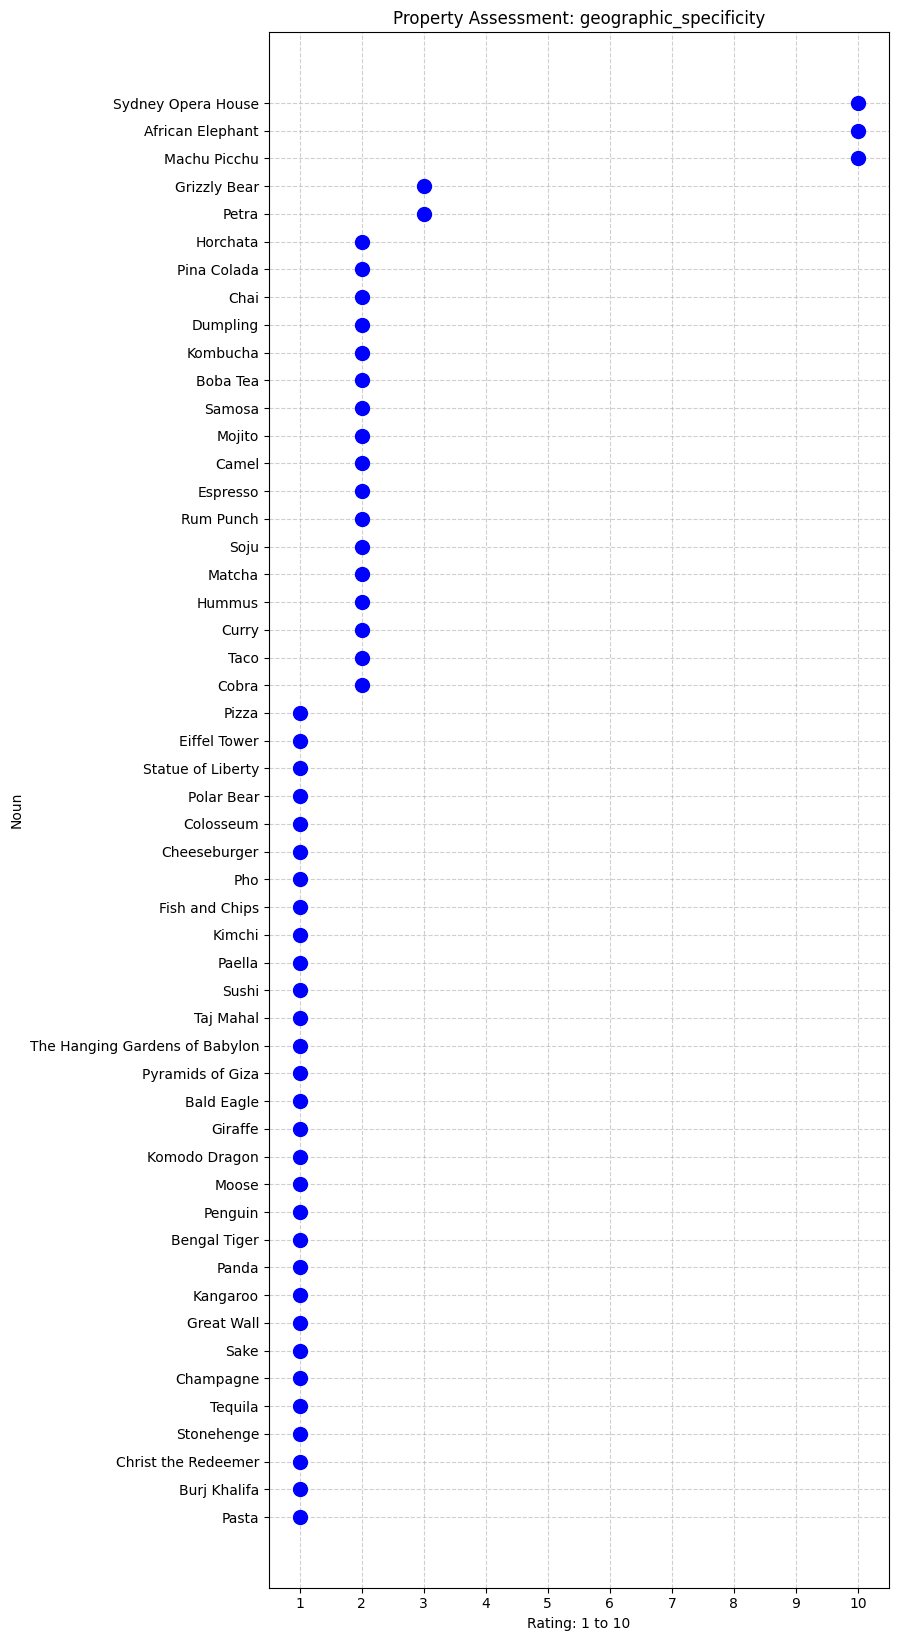

In [10]:
# Property Assessment dot plots of all nouns
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

result_file = "ratings.jsonl"

# Read ratings and parse
with open("ratings.jsonl", "r") as f:
  result_file = f.read().strip()
  if result_file.startswith('[') and result_file.endswith(']'):
    data = json.loads(result_file)

df = pd.DataFrame(data)

properties = df['property'].unique()

# Build dot plots
for p in properties:
  subset = df[df['property'] == p].sort_values(by="rating")
  num_nouns = len(subset)
  height = num_nouns * 0.35 + 2
  plt.figure(figsize=(8, height))
  plt.scatter(subset["rating"], subset["noun"], color="blue", s=100, zorder=3)
  plt.title(f"Property Assessment: {p}")
  plt.xlabel("Rating: 1 to 10")
  plt.ylabel("Noun")
  plt.xticks(np.arange(1, 11, 1))
  plt.xlim(0.5, 10.5)
  plt.grid(True, linestyle="--", alpha=0.6)

  # save plots
  save_plot = p.replace(" ", "_").lower()
  plt.savefig(f"{save_plot}.png")
  plt.show()

**1. Property Assessment: energy_level:**

For the first dot plot, we assess the nouns based on its energy level where it ranges from primary producer to an apex predator or a high caloric input. This is mainly meant for nouns that are either an global animal or food, however, rating all the nouns within this category shows that some of the landmark structures are rated quite highly. With this plot, the Burj Khalifa has the highest rating of 10 and seems to be the only noun with that rating. I find it a bit odd that it classified Petra as a rating of 5. This could be because the LLM lacks precision, which is also why a large amount of the other nouns are grouped into a rating of 3. There is poor differentiation and has difficulty interpreting the noun to classify the global animals/foodnouns, even when the assessment is targeted towards that noun group.

**2. Property Assessment: temperature:**

This property assessment rates the nouns based on room temperature being the lowest rating and a precise temperature needed for the noun being the highest rating. When we say precise, it's meant to classify it as hot or cold. While this assessment is meant for nouns that are global foods/drinks, I observed that it assessed the animals adequately. The polar bear being the highest rating suggests that it does in fact need to be in an environment where its temperature is precise. Perhaps when it rates landmarks/structures, I would assume it would rate them according to the country's or area's temperature. Otherwise it's longevity in a certain temperature range. For example, when it rates the Statue of Liberty a 3, this suggests that it will be sustained in either cold or hot temperatures, considering the fact that New York witholds both kinds of environments.

**3. Property Assessment: symbolic_value:**

This property assessment rates the nouns according to its symbolic value, where it being a practical or functional is the lowest rating to the noun being iconic or popularly known is the highest rating it could receive. I figured this would maybe assess the drinks, food, or animals as to how popular or how known they are around the world. Once again, majority of the nouns have a rating of 3, which proves that the LLM lacks proper judgement within this prompt. For example, fish and chips is known to be a national dish that represents a culture, but there is the inability to define abstract significance. However, there are nouns that are universally recognized, such as the Taj Mahal and the Eiffel Tower. Matcha also has a high rating because it heavily tied to Japan's culture. Within the animal nouns, the LLM does not grasp the concept of what cultural significance they possess, because it's probably assessing them more in a general sense.

**4. Property Assessment: historical_age:**

This property assessment rates the nouns based on its historical age as 1 being very recently created through 10 being ancient or on a geological time scale. Based on the plot, the LLM poorly differentiates the nouns as majority of them are a rating of 3. It was, however, able to catch the landmarks/structures somewhat accurately, since the Great Wall and the Stonehenge are centuries-old structures. In contrary, the assessment on structures ends up falling flat because the Burj Khalifa is not as old as the other structures or even the global foods. A common pattern among this LLM across all plots is that it fails to rate nouns between the scale. If it were me, I would rate the nouns from a range of 3 to 5 if I did not know its historical significance. The LLM fails to do that.

**5. Property Assessment: geographic_specificity:**

This property assessment rates the nouns according to how specific they are according to regions around the globe. If it's widely known and covers a large part of a continent/country then it will be of low rating. If the noun is classified as part of a specific or small region, then it will be a high rating. The LLM seems to have somewhat of a grasp in understanding global presence of the nouns. For example, the African Elephant, and the Opera House are heavily tied to being a part of a specific region among continents. However, if it is able to assess the Opera House accurately, then the other landmarks/structures should also be of high rating, since they are to be unique and one of a kind. Although I will assume that the structures were of low rating because them being widely known overrides the structures being part of a specific region. It seems to rate the food nouns logically, as items such as pasta, coffee, and pizza are consumed globally.

In [11]:
# Property assessment with improved the baseline prompts
import json
# Testing all properties
def load_data(nouns_text='nouns.txt', prompts_text='improved-prompts.jsonl'):
    # read nouns and prompts from the file
    # nouns
    with open(nouns_text, 'r') as f:
        nouns = [line.strip() for line in f if line.strip()]

    # prompts
    properties = []
    with open(prompts_text, 'r') as f:
        for line in f:
            properties.append(json.loads(line))

    return nouns, properties

In [12]:
#Baseline prompts and property assessment
def property_assessment(nouns_text, properties_text, pipe, tokenizer):
    ratings = []
    count = 0

    # iterate through prompts
    for properties in properties_text:
        property_name = properties['property']
        pre_prompt = properties['pre-prompt']

        # iterate through nouns
        for nouns in nouns_text:
            count += 1

            # get ratings
            index = count
            print(f"Running: {property_name} for {nouns}...")
            get_ratings = rating(nouns, pre_prompt, pipe, tokenizer)

            result = {
                "noun": nouns,
                "property": property_name,
                "rating": get_ratings
            }

            ratings.append(result)

            if get_ratings is None:
                print(f"Failed for {nouns}.")
            else:
                print(f"Rating: {get_ratings}")
    # summary
    successful_ratings = sum(1 for item in ratings if item['rating'] is not None)

    print(f"\n\n--- Assessment Session Ended ---")
    print(f"Total ratings collected: {len(ratings)}")
    print(f"Successful numerical ratings: {successful_ratings}")

    # Print the full list of collected ratings
    print("\n--- Full Collected Data (List of Dictionaries) ---")
    return ratings

In [13]:
# Get results
nouns_text, property_text = load_data(prompts_text='improved-prompts.jsonl')
final_results = property_assessment(nouns_text, property_text, pipe, tokenizer)
print(final_results)

Running: energy_level for Pasta...
DEBUG: Prompt sent to model: 
<|user|>
Evaluate how much energy or dynamism this noun represents, produces, or evokes — whether physical (like motion, heat, power) or abstract (like excitement, activity, intensity). Think about how 'energetic' it feels or behaves compared to an average everyday object. On a scale from 1 (very passive or still) to 10 (extremely dynamic, active, or powerful), where 5 represents moderate activity or liveliness, rate this noun. Use the full range when appropriate, including mid-values for objects or ideas with moderate motion or energy. Output ONLY a single number from 1–10.Pasta<|end|>
<|assistant|>

Rating: 3
Running: energy_level for Sushi...
DEBUG: Prompt sent to model: 
<|user|>
Evaluate how much energy or dynamism this noun represents, produces, or evokes — whether physical (like motion, heat, power) or abstract (like excitement, activity, intensity). Think about how 'energetic' it feels or behaves compared to an av

In [14]:
# Improved ratings
# Upload ratings to file
import pandas as pd
import json

with open("improved-ratings.jsonl", "w") as f:
  json.dump(final_results, f)

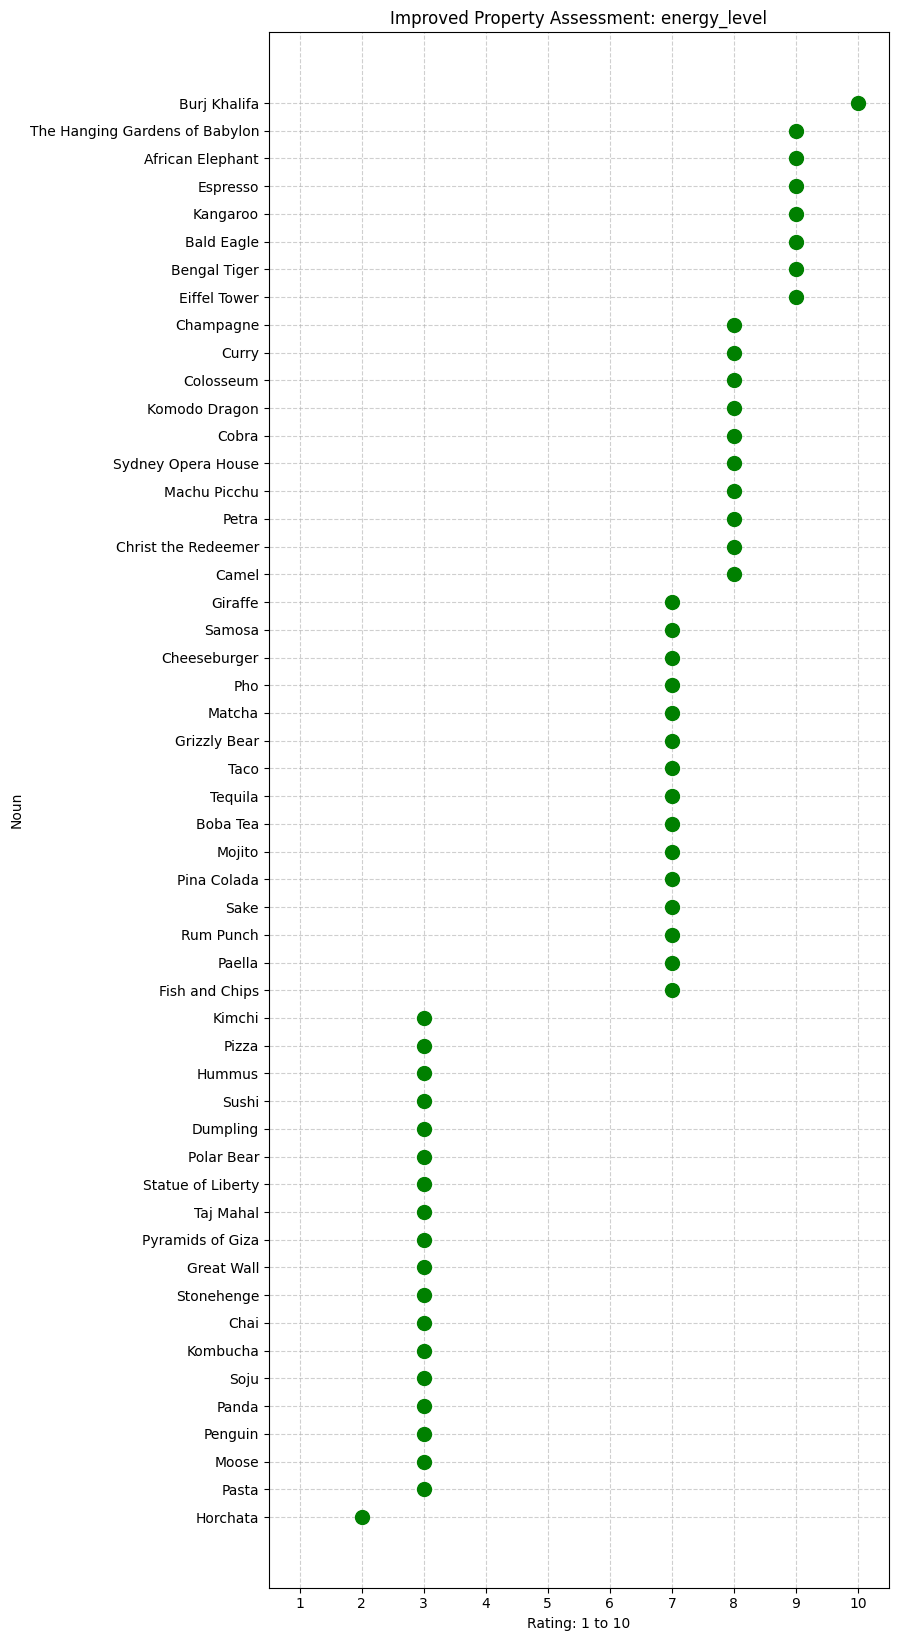

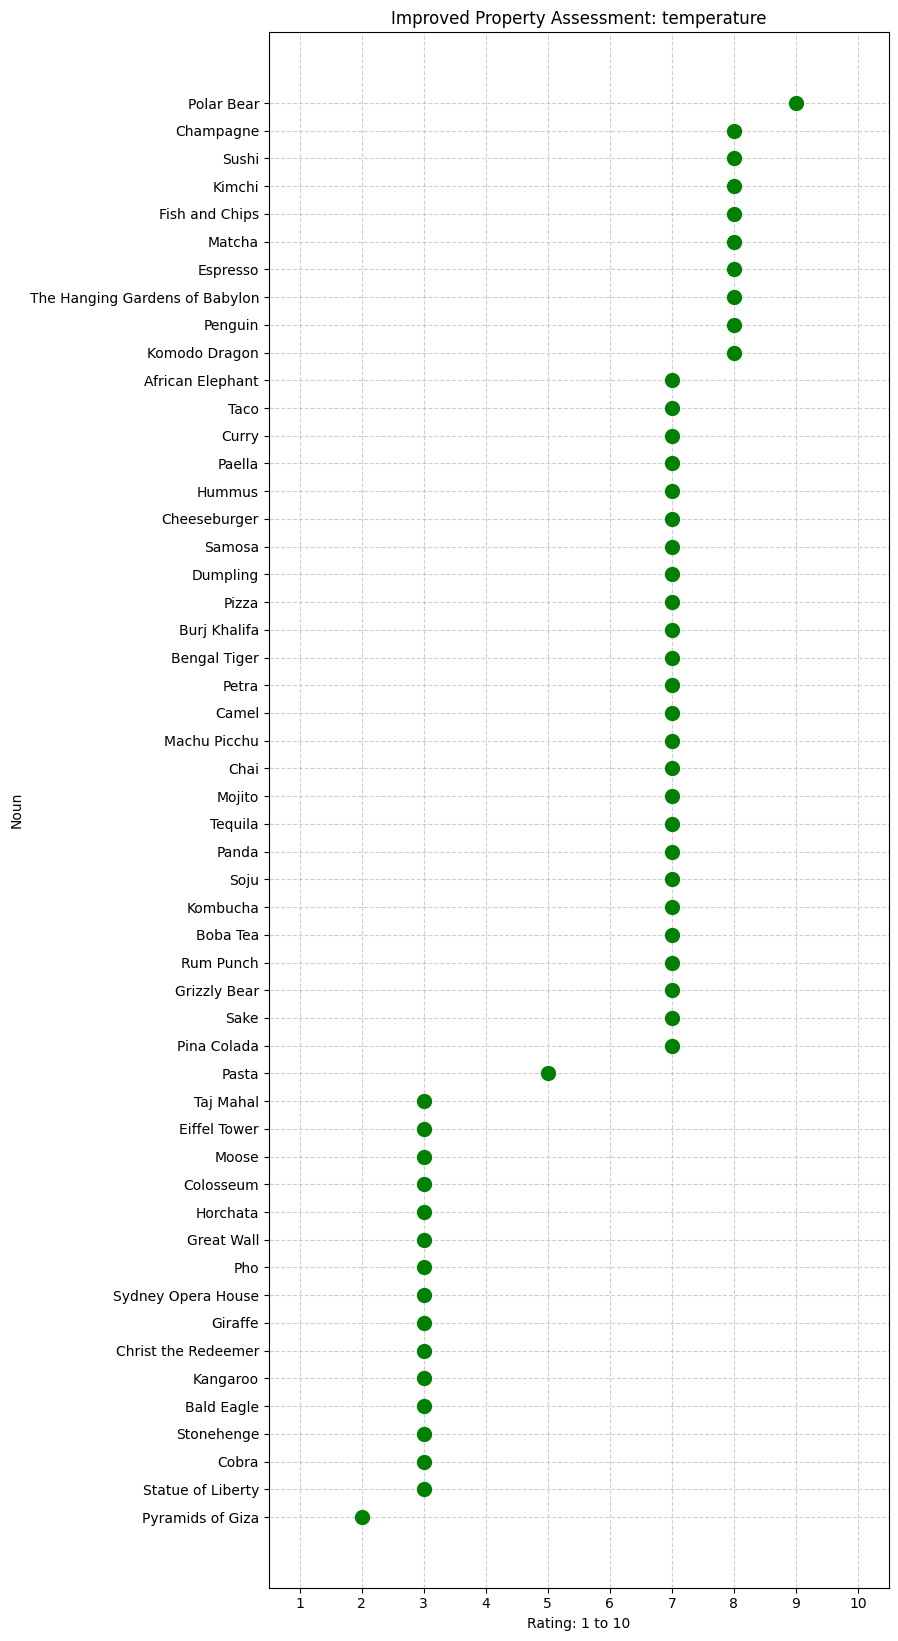

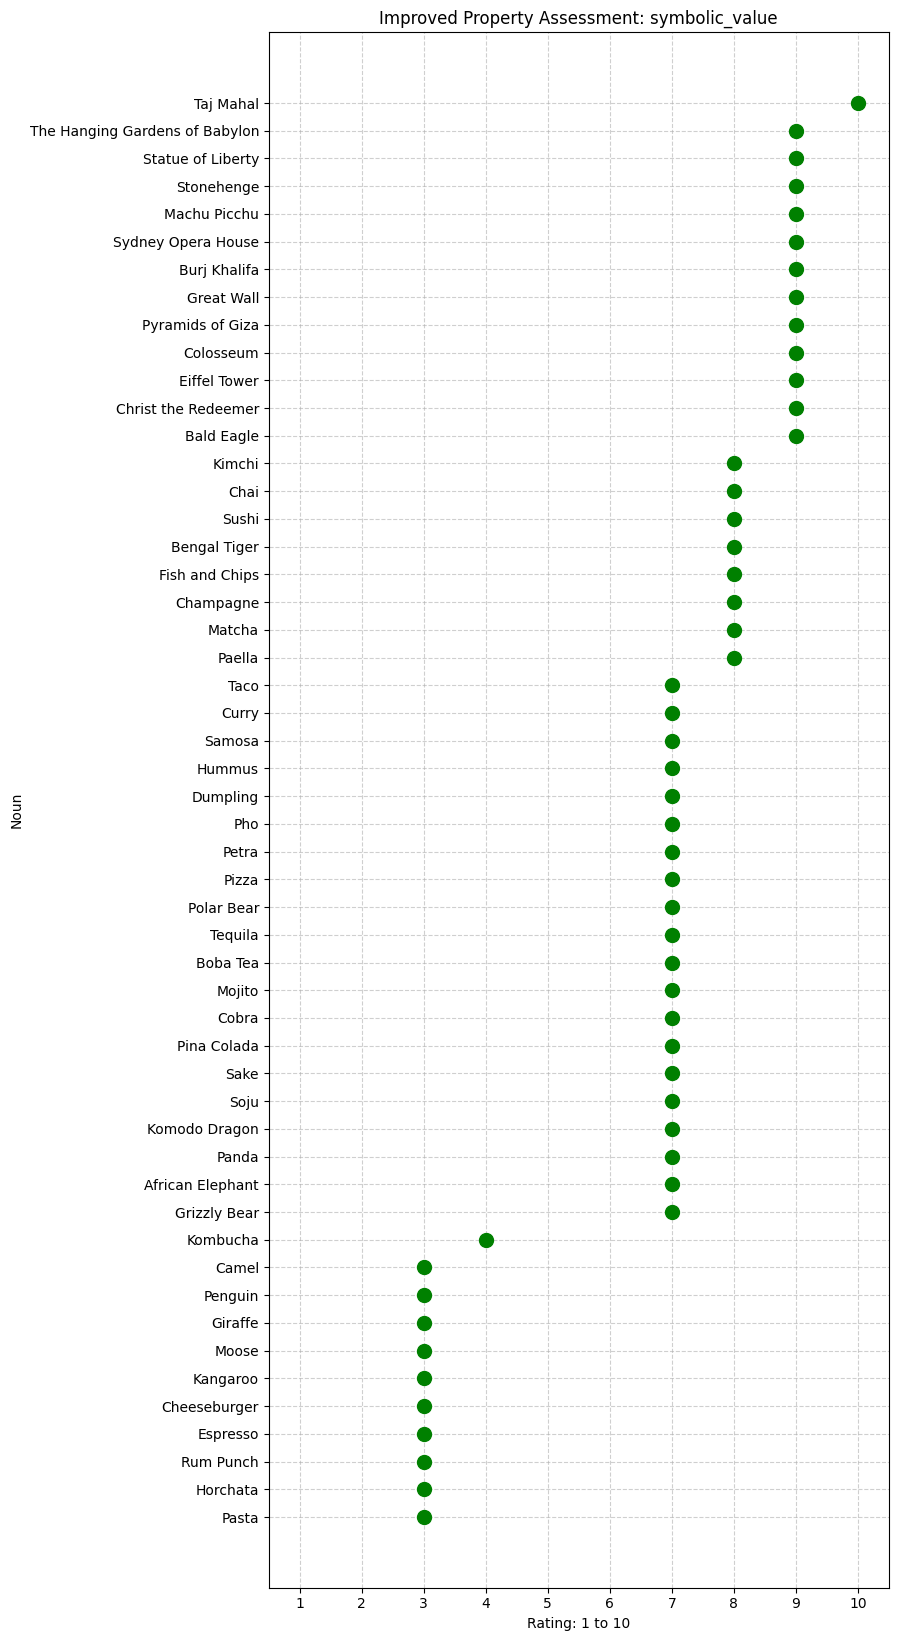

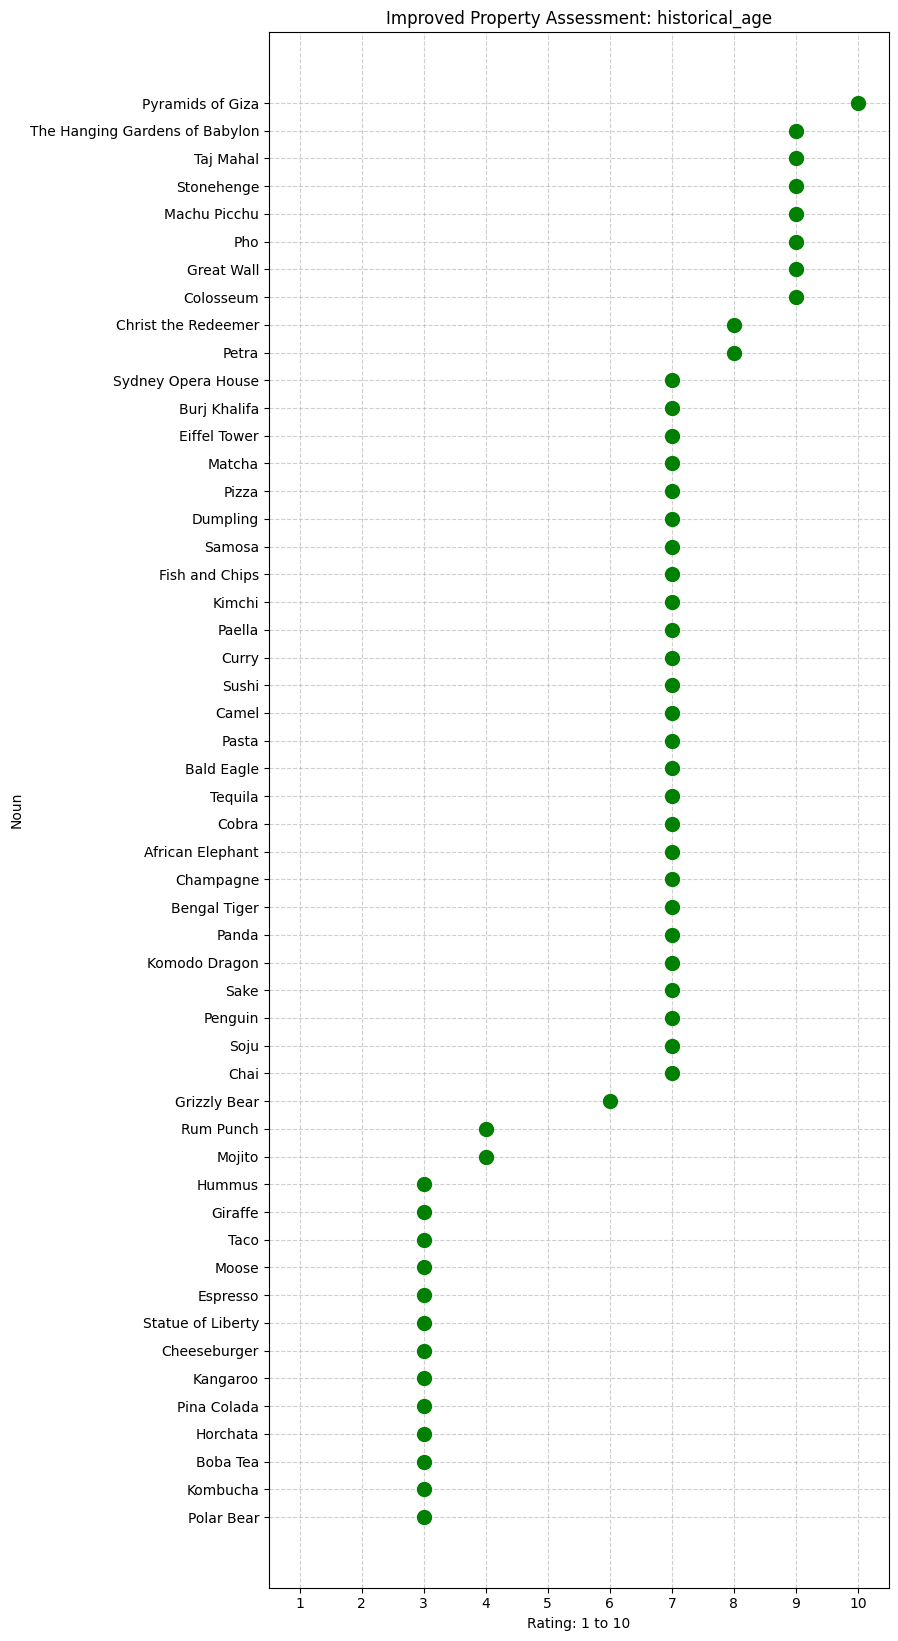

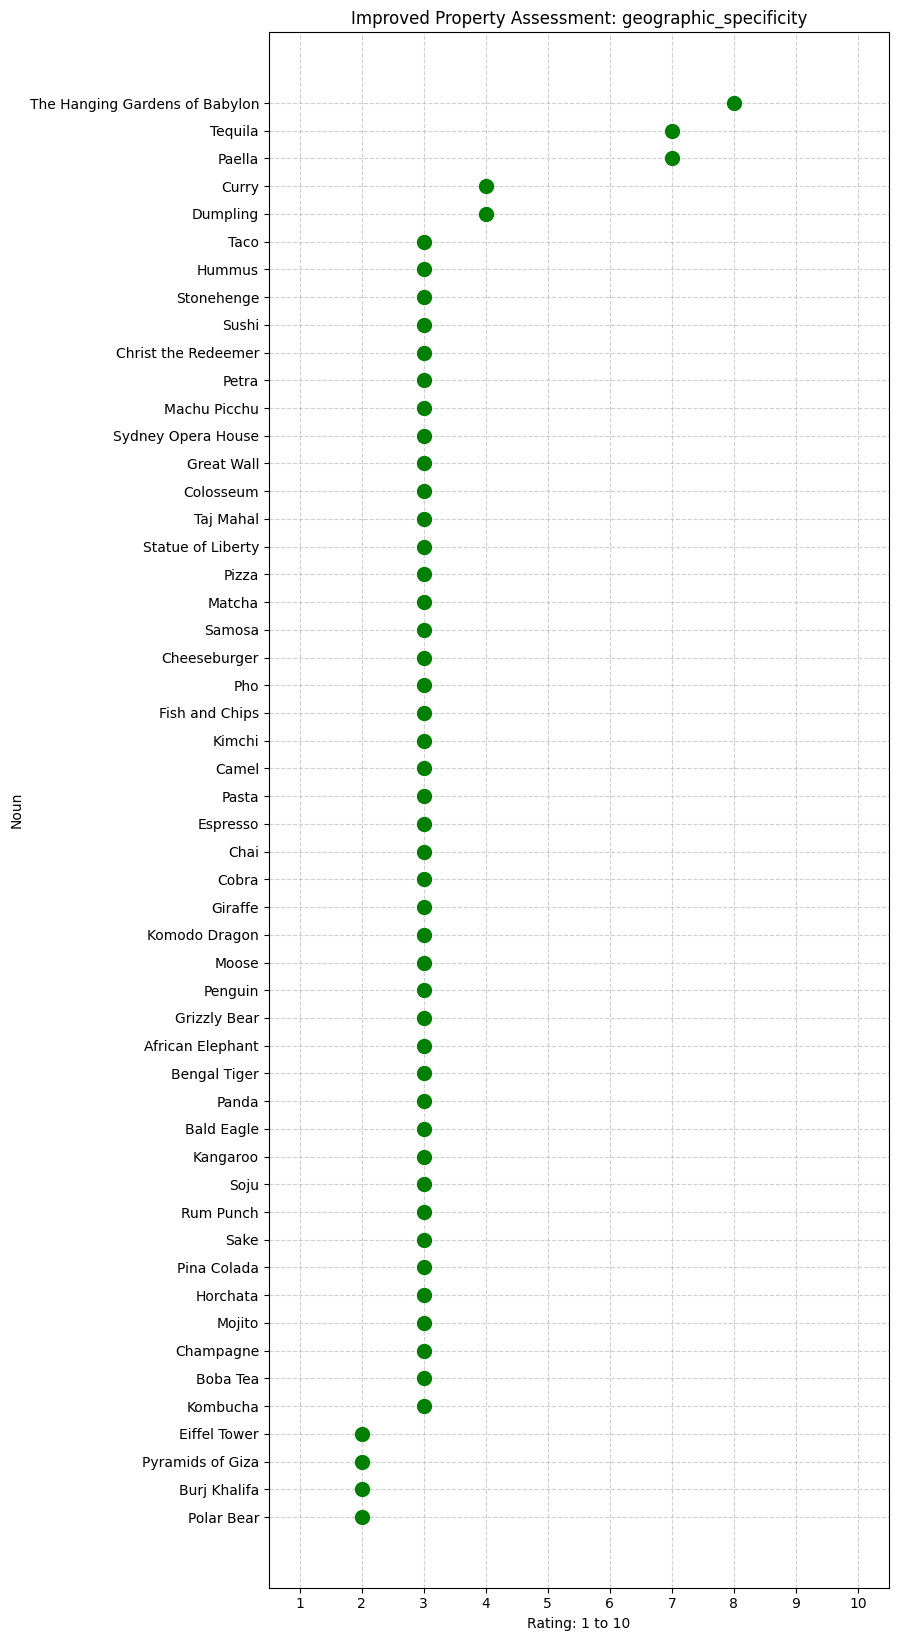

In [15]:
# Property Assessment dot plots of all nouns
import pandas as pd
import matplotlib.pyplot as plt
import json
import os

result_file = "improved-ratings.jsonl"

# Read ratings and parse
with open("improved-ratings.jsonl", "r") as f:
  result_file = f.read().strip()
  if result_file.startswith('[') and result_file.endswith(']'):
    data = json.loads(result_file)

df = pd.DataFrame(data)

properties = df['property'].unique()

# Build dot plots
for p in properties:
  subset = df[df['property'] == p].sort_values(by="rating")
  num_nouns = len(subset)
  height = num_nouns * 0.35 + 2
  plt.figure(figsize=(8, height))
  plt.scatter(subset["rating"], subset["noun"], color="green", s=100, zorder=3)
  plt.title(f"Improved Property Assessment: {p}")
  plt.xlabel("Rating: 1 to 10")
  plt.ylabel("Noun")
  plt.xticks(np.arange(1, 11, 1))
  plt.xlim(0.5, 10.5)
  plt.grid(True, linestyle="--", alpha=0.6)

  # save plots
  save_plot = p.replace(" ", "_").lower()
  plt.savefig(f"{save_plot}_improved.png")
  plt.show()

**1. Property Assessment: energy_level**

According to the dot plot, the LLM seems to do a better job at dispersing the clusters as well as rate them somewhat better. For example, the LLM had previously rated espresso an 8 and has now rated it a 9, along with the African Elephant, which had a lower rating before. While it may be a slight change, it has gotten better with the ratings. However, rating the landmark/structures is a bit tricky within this category. This is why the improved prompts gives a consideration to tourism activity or its construction. For example, the Burj Khalifa has a high rating due to the fact that it is the tallest building in the world and is one of the most popular tourist attractions.

**2. Property Assessment: temperature**

The prompt has definitely improved the ratings for the nouns, since we specified what kind of nouns depend on contextual temperature sensitivity. The baseline prompts had to force LLM to figure that out on its own, however we've allowed it to disperse the ratings across the board and accurately as well. Giving the prompt a constraint has shifted the global animals nouns into a more mid range. Rating foods and animals based on high dependence of temperature has been relatively stable.

**3. Property Assessment: symbolic_value**

The improved prompt for symbolic_value has heavily improved the ratings for landmark/structures. Because these global structures are known symbollicaly by default around the world, you would assume the LLM would automatically rate them higher. However, the baseline prompts had caused nouns like foods and animals to hold a higher symbolic value than known landmarks. With the improved baseline prompts, the LLM quickly rates all the landmarks higher than the global animals and foods.

**4. Property Assessment: historical_age**

The overall success of this prompt for historical age is moderate. The nouns cluster mainly with a rating of 3 and 7. The prompt somewhat fails to use the full range of rating. For example, the LLM rates the Burj Khalifa a 7 which is quite high considering its completion date was 2010. I would expect the Statue of Liberty to have a higher rating than the Burj Khalifa. Overall there is partial success comparre

**5. Property Assessment: geographic_specificity**

The improved prompt is not as successful as majority of the nouns are rated 3. The nouns have only shifted over by 1 or 2 from the baseline prompts. Similar to the symbolic value property assessment, the landmarks/structures should be ranked the highest since they are all unique to a specific region. For example, a polar bear should be on the higher end of the rage since it is specific to Antarctica only.

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import os

baseline_file = 'ratings.jsonl'
improved_file = 'improved-ratings.jsonl'
output_dir = 'comparative_plots'
SCORE_KEY = 'rating'
EXPECTED_KEYS = ['noun', 'property', SCORE_KEY]


# load data
def load_data(filename, source_name):
    """Loads and cleans data, handling the single-line JSON array format."""
    results = []
    with open(filename, 'r') as f:
        file_content = f.read().strip()

        # Parse
        if file_content.startswith('[') and file_content.endswith(']'):
            results = json.loads(file_content)
        else:
          results = [json.loads(line) for line in file_content.split('\n') if line.strip()]

    df = pd.DataFrame(results)

    df.columns = df.columns.str.lower()

    if SCORE_KEY not in df.columns:
        if SCORE_KEY.lower() in df.columns:
             df = df.rename(columns={SCORE_KEY.lower(): 'rating'})
        else:
             return pd.DataFrame()
    else:
        df = df.rename(columns={SCORE_KEY: 'rating'})

    # Parse data
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
    df = df.dropna(subset=['noun', 'property', 'rating']).copy()

    df = df.rename(columns={'rating': f'{source_name}_rating'})

    return df[['noun', 'property', f'{source_name}_rating']]


# Merge baseline and improved
def compare_assessments(baseline_file, improved_file):
    baseline_prompts = load_files(baseline_file, 'baseline')
    improved_prompts = load_files(improved_file, 'improved')

    if baseline_prompts.empty or improved_prompts.empty:
        return pd.DataFrame()

    # Merge both ratings on the 'noun' and 'property' columns
    merge_ratings = pd.merge(
        baseline_prompts,
        improved_prompts,
        on=['noun', 'property'],
        how='inner'
    )
    return merge_ratings

# --- 3. Comparative Plotting Function (Core Request) ---
def compare_plots(merge_ratings, output_dir):

    #if not os.path.exists(output_dir):
     #   os.makedirs(output_dir)

    properties = merge_ratings['property'].unique()

    for p in properties:
        # Filter and sort by the IMPROVED rating (as requested)
        subset = merge_ratings[merge_ratings['property'] == p].sort_values(by="improved_rating", ascending=True)

        num_nouns = len(subset)
        height = num_nouns * 0.35 + 2

        fig, ax = plt.subplots(figsize=(8.5, height))

        # Plot
        y_pos = np.arange(num_nouns)

        # 1. Baseline Dots (Blue)
        ax.scatter(
            subset["baseline_rating"],
            y_pos,
            color="blue",
            s=100,
            label='Baseline',
            alpha=0.8
        )

        # 2. Improved Dots (Green)
        ax.scatter(
            subset["improved_rating"],
            y_pos,
            color="green",
            s=100,
            label='Improved',
            alpha=0.9
        )

        # Axes and Labels
        ax.set_yticks(y_pos)
        ax.set_yticklabels(subset['noun'])

        ax.set_title(f"Comparative Assessment: {p}", fontsize=14)
        ax.set_xlabel("Rating 1 to 10", fontsize=12)
        ax.set_ylabel("Noun", fontsize=12)
        ax.set_xticks(np.arange(1, 11, 1))
        ax.set_xlim(0.5, 10.5)
        ax.grid(True, linestyle="--", alpha=0.6, axis='x')

        # Save the plot
        save_plot = p.replace(" ", "_").lower()
        plt.tight_layout()
        plt.savefig(f"{save_plot}_comparitive.png")
        plt.show()

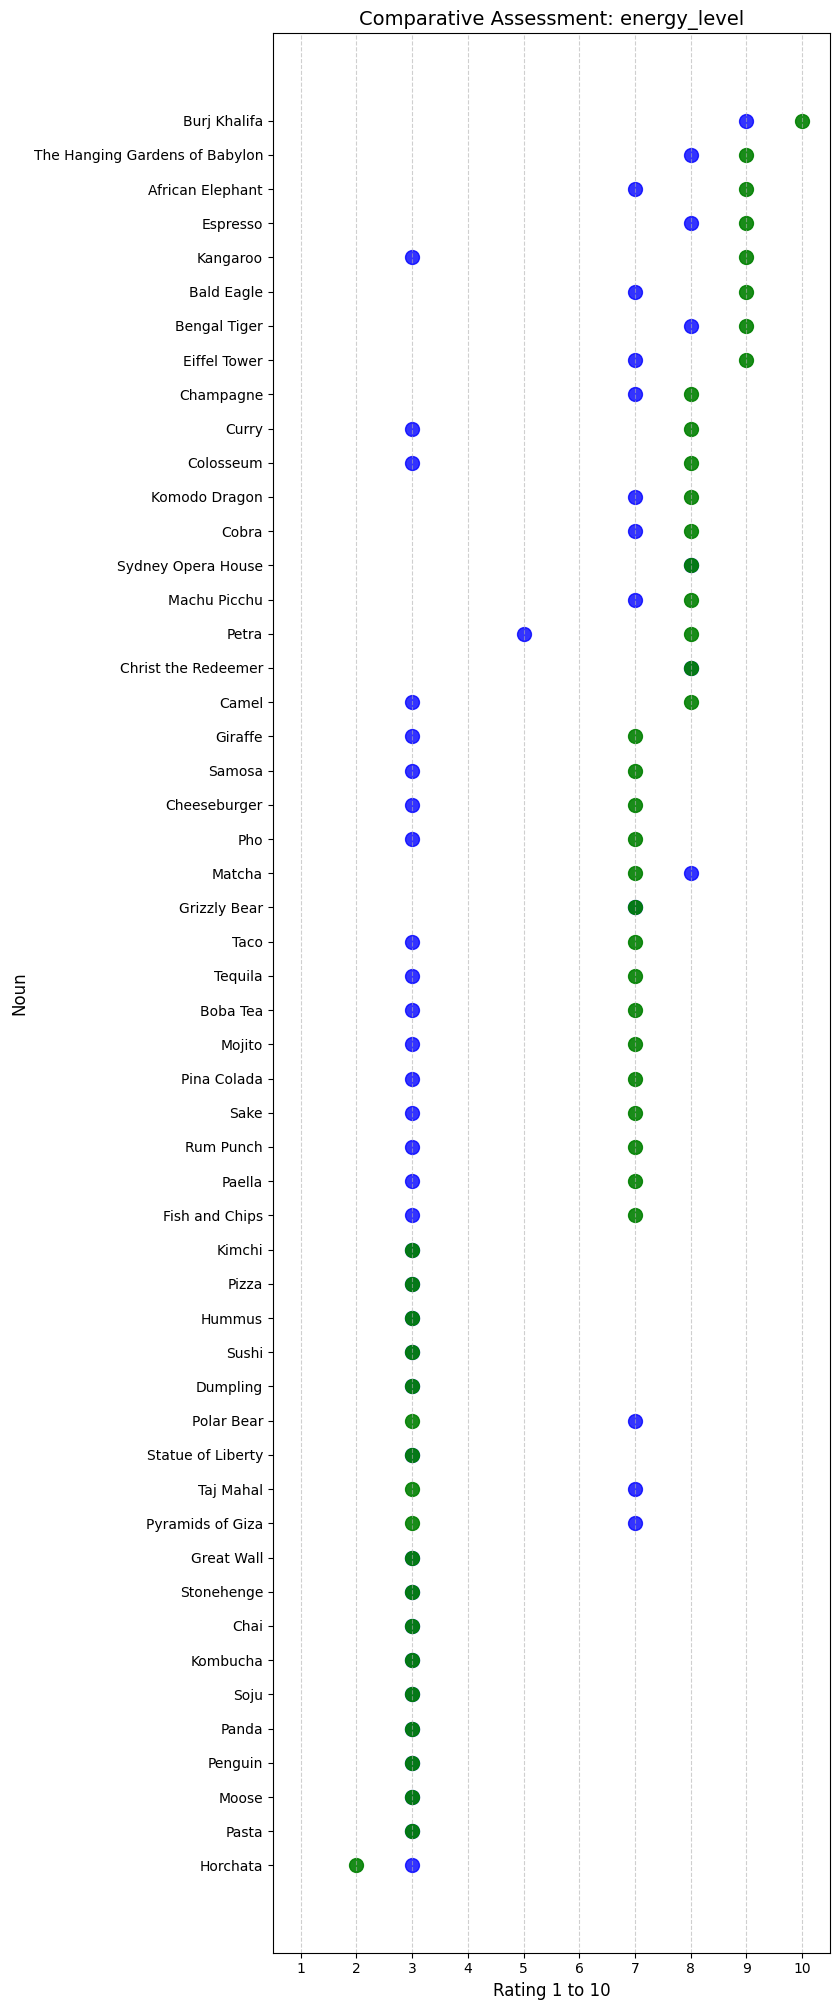

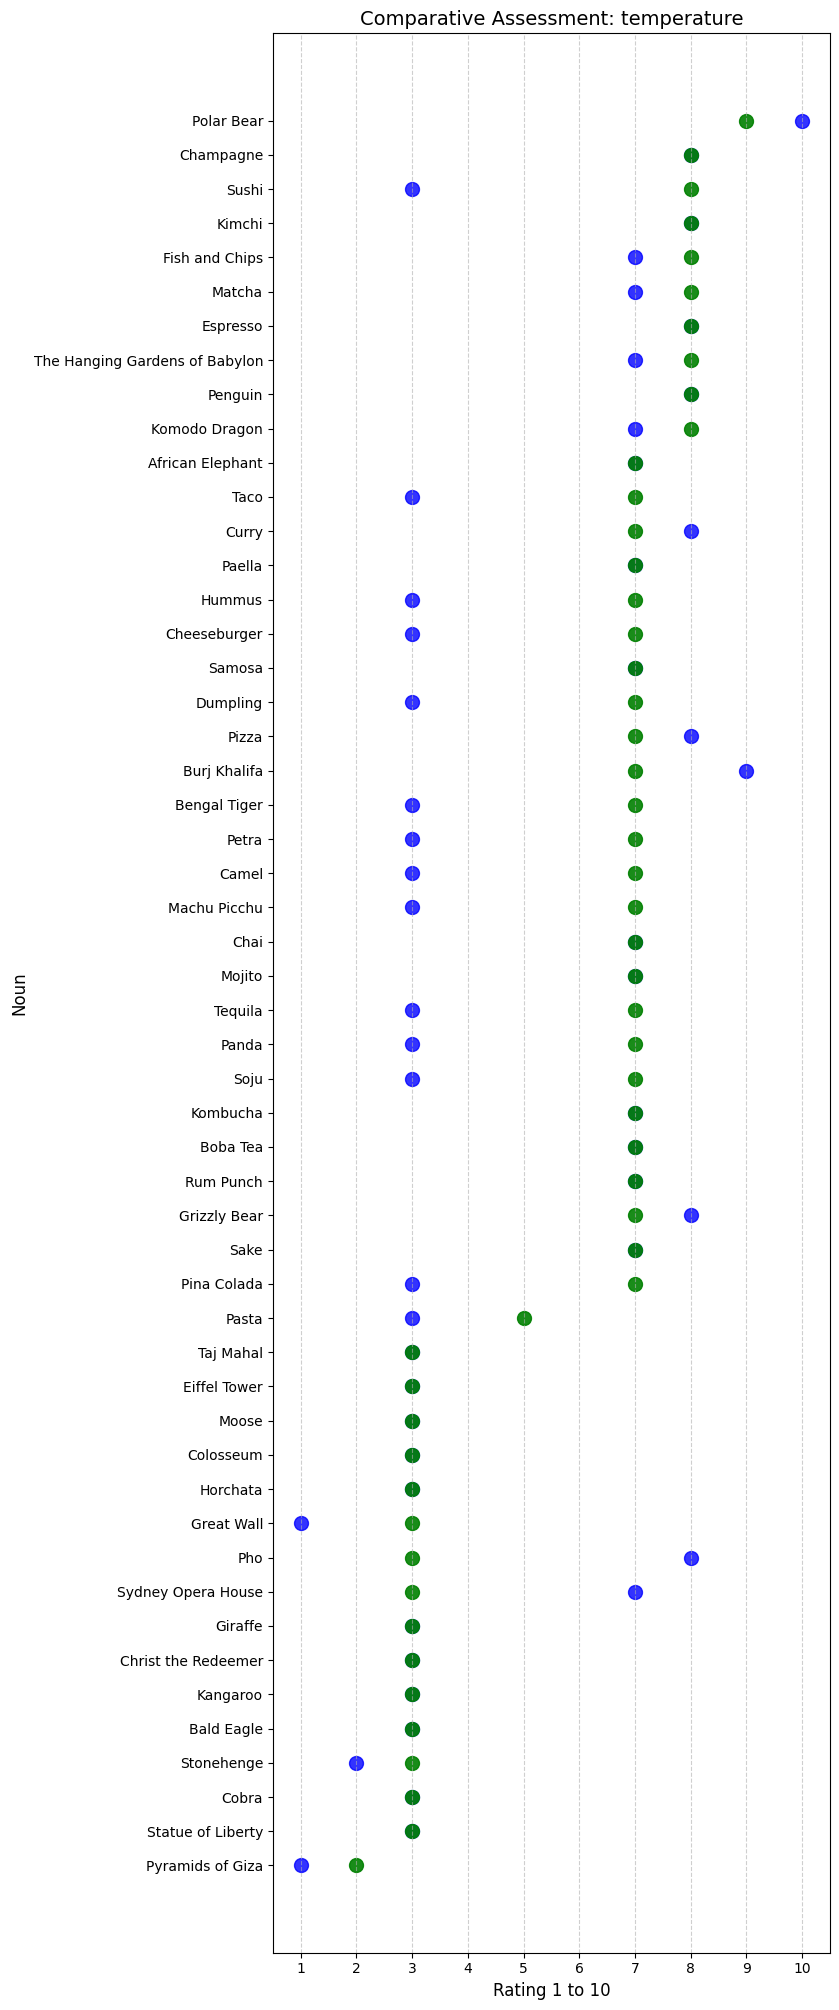

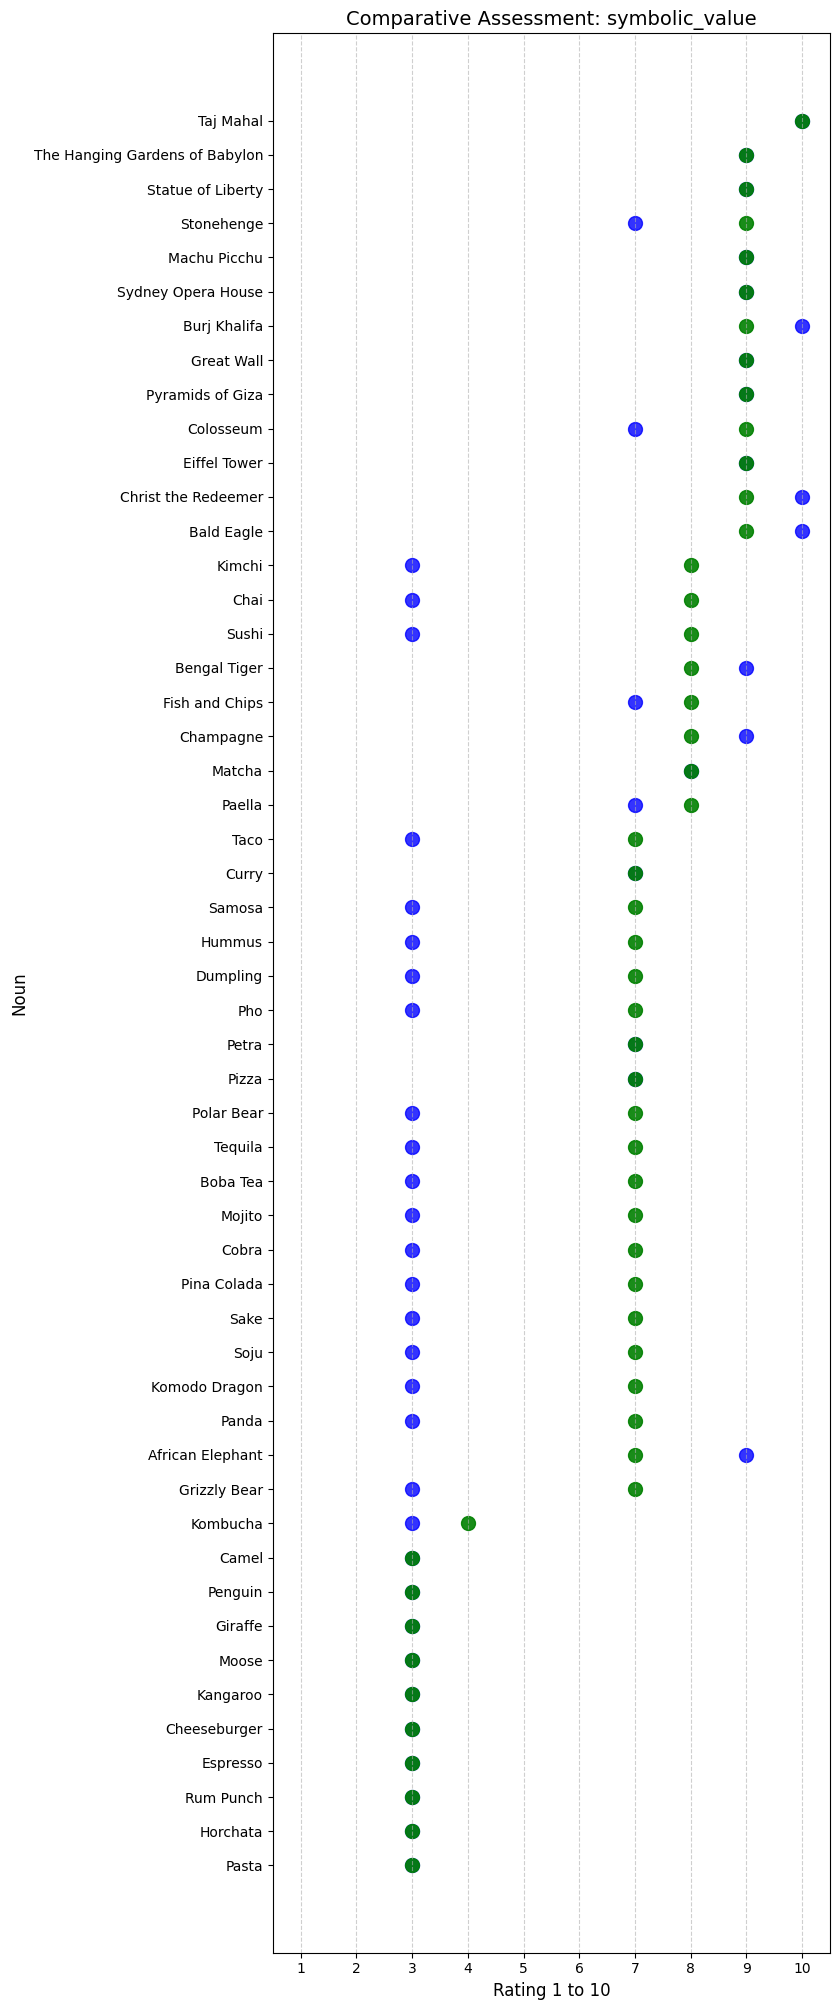

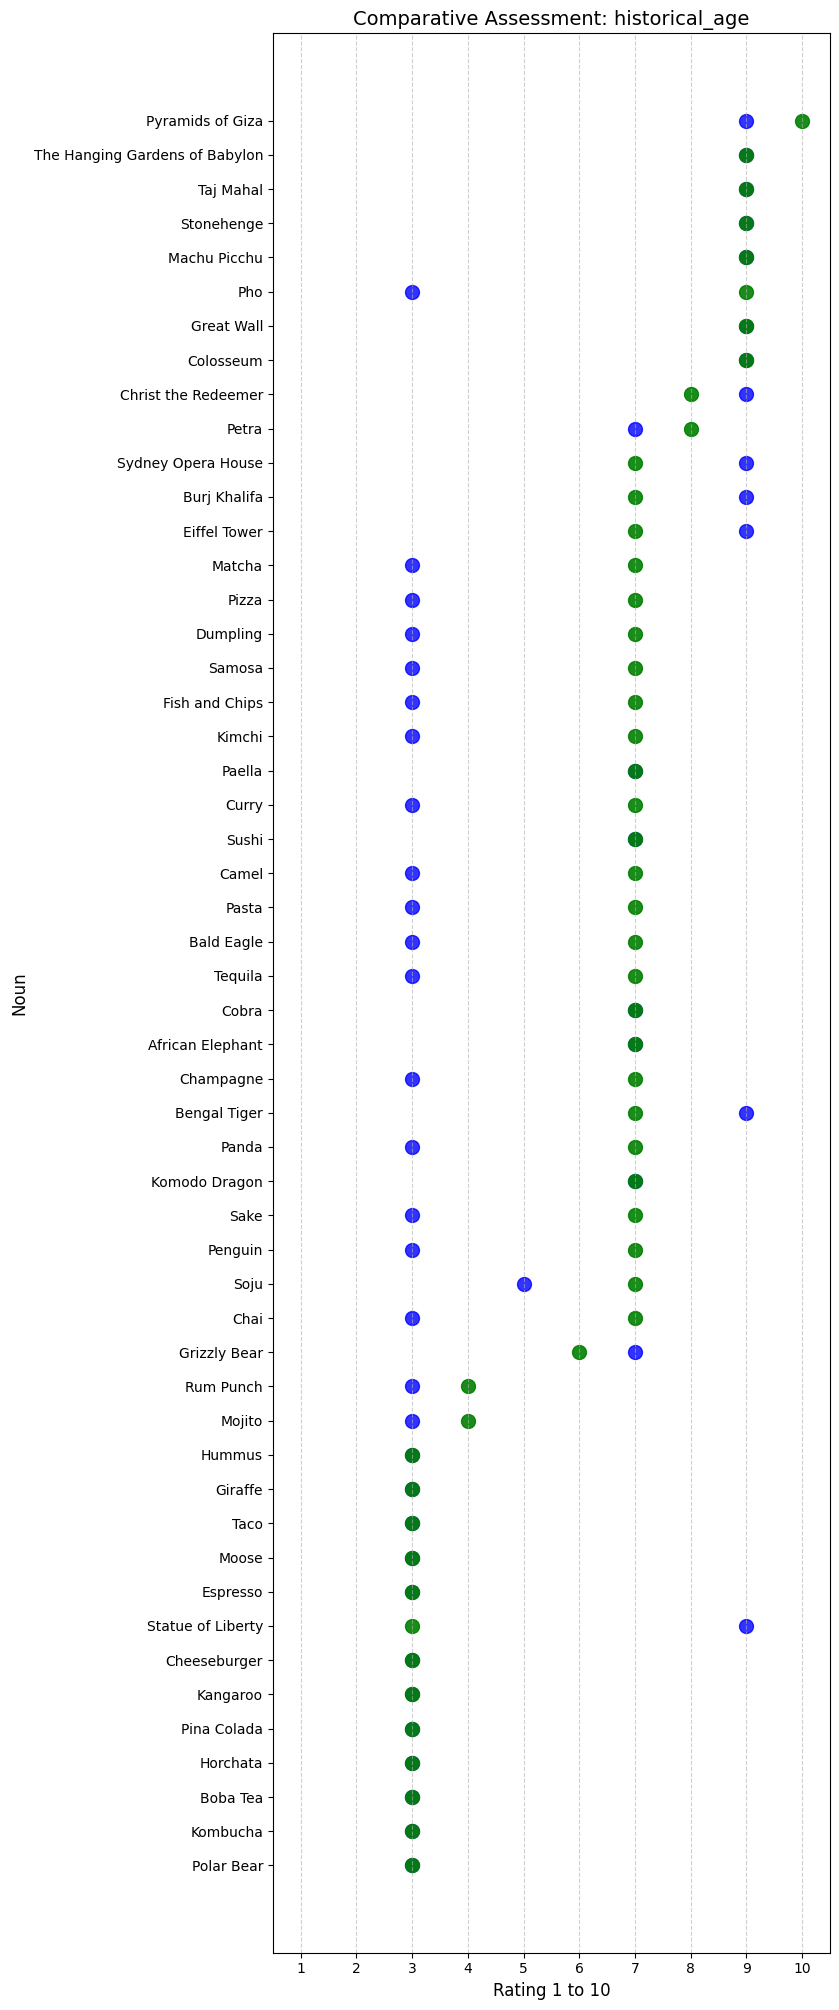

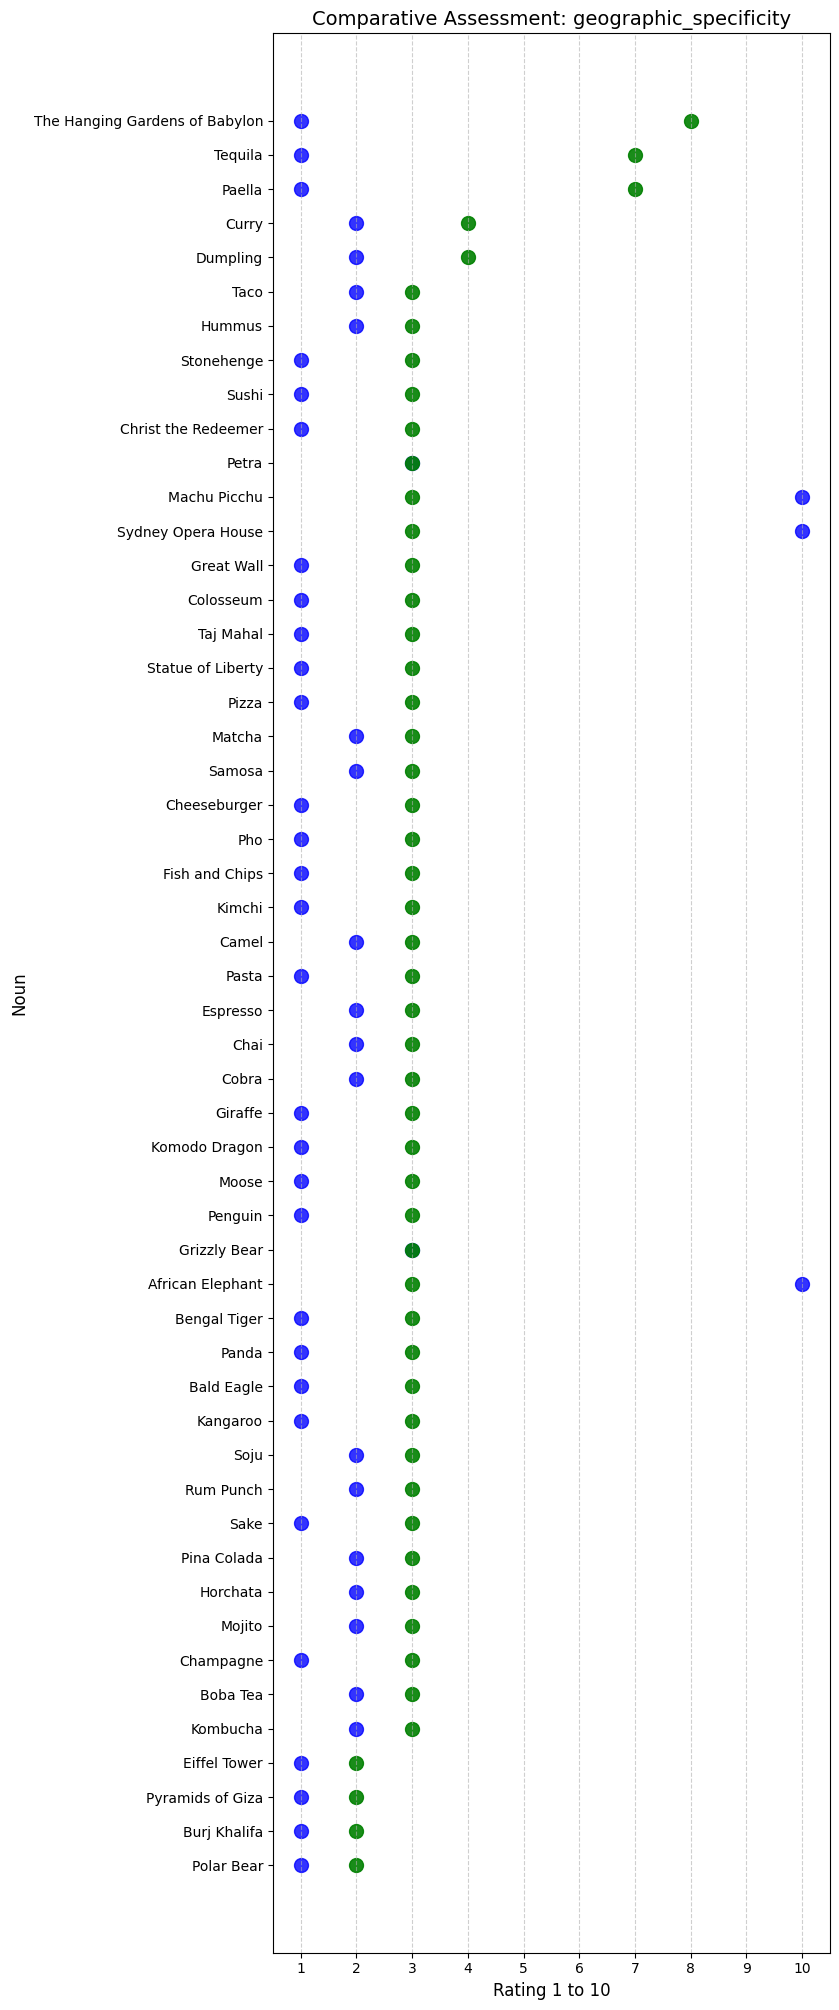

In [24]:
merged_data = compare_assessments(baseline_file, improved_file)
compare_plots(merged_data, output_dir)

**Baseline & Improved Reflection**

**1. energy_level:**

For both baseline and improved prompts, the clustering is prominent with a rating of 3. This could be the LLM's way of interpreting the nouns into a more neutral ground. However, clustering them like this limits its variance across the plot. For the baseline prompts (blue), it seems that the nouns were more dispersed than the improved ratings (green). The baseline lacked the ability to correctly rate the animals, while the improved prompt shifted the animals and landmarks to a higher structure.

**2. temperature:**

With the baseline prompts (blue), we do not see clustering of the nouns, as much as the improved prompts (green) clusters. Although clustering is present for the improved prompts, the ratings tend to be more accurate, especially the landmarks/structures. Majjority of the animal nouns were correctly placed in the 6-7 range, in which they moderately depend on thermal regulation.

**3. symbolic_value:**

The visualization confirms that the improved prompts have worked successfully. In the baseline prompts (blue), the LLM was unable to give a high rating to all the landmarks/structures since these should be "symbolic" in one way or another by default. But with the improved prompts (green), the LLM was able to rank them high successfully. Furthermore, the rankings of food, such as espresso and cheeseburger follow the improved prompts guide as they do not really hold much symbolic value even if they might be popularly known.  

**4. historical_age:**

The improved prompts (green) tends to cluster the nouns a lot more than the baseline prompts (blue). While both are prone to clustering, the baseline is able to somewhat disperse throughout the ratings. Animals should be ranked higher in this sense as they have a greater historical age than most of these foods and structures. Modern nouns have a bit difficulty being placed from 3-6.

**5. geographic_specificity:**

The improved prompt (green) has failed, however there is not much difference than the baseline prompt (blue). It seems that the LLM struggled to differentiate between globally known and specific with both prompts. This is because we can see that polar bear has too much of a low rating. Both prompts have also failed to develop mid range ratings.

**Final Reflection**

For the noun selection method, I wanted to keep the nouns diverse but also keep a common theme so that the property assessments would work well when rating the nouns (keeping a global theme). Foods and drinks were meant to test the temperature and energy level property assessments. The global animal nouns were meant to test against all property assessments. The structures/landmarks were mainly created to test against symbolic value and historical age property assessments. The given property assessments were chosen in terms of them having the ability to be quantifiable yet complex enough so that I can study the model's behavior before and after improving the prompts. Along with the clear zero-shot strategy, when improving the baseline prompts, I needed to specify what nouns could fall in the mid-range of ratings so that it can disperse all the nouns adequately. This was to prevent all the nouns from continuously clustering together. With the LLM, I sometimes had to treat it as if it almost had no context of the nouns when rating them. Furthermore, I had to apply constraints of what the LLM would automatically assume of the noun so it can follow the property asessment subjectively. Using these techniques has allowed the ratings to improve. The LLM was able to demonstrate its ablility in rating these global nouns by estimating the context of the properties. The most successful properties were symbolic_value, temperature, and energy_level. These property assessments were able to break the tight baselines and provide varied, yet accurate ratings. The historical_age and geographic_specificty property assessments performed fairly well, but not as good as the other properties. It continued to cluster the nouns even after adding constraints to the prompts. Overall, model performed the qualitative assessment successfully, but only with the strict reliability and guidance of prompt engineering.